# preprocess of recurrence

In [79]:
# 基本的なライブラリ
import sys
from tqdm import tqdm
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# パイプライン
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from pipelines import *

# データ分割
from sklearn.model_selection import train_test_split

# スケーリング
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 次元削減
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import SparsePCA

import config
import functions

SEED = config.SEED
functions.fix_seed(SEED)
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
STRATIFY_NAME = "RFS_STATUS"
%matplotlib inline

# データ読み込み

In [65]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")

## カラムの順序変更（読みやすさのため）

In [66]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    _df = df.copy()
    df_tmp = _df.filter(regex=regex)
    # 元のdfから落とす
    _df.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(_df, df_tmp, right_index=True, left_index=True)


def sort_columns_by_knowledge(df):
    _df = df.copy()
    # 癌の種類
    _df = align_columns(_df, "^CANCER_")
    # 重要そう（直感）な特徴量
    _df = align_columns(_df, "^ER_|^HER2_|^TUMOR_")
    # 治療の種類
    _df = align_columns(_df, ".*THERAPY$|^BREAST_SURGERY")
    # target系の種類（OS, RFS, VITAL）
    _df = align_columns(_df, "^OS_.*|^RFS_.*|^VITAL_.*")
    return _df


df_clinical = sort_columns_by_knowledge(df_clinical)

In [67]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)

display(df_MB.shape, df_MTST.shape)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_clinical.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MTST.pkl")
del df_patient, df_sample, df_clinical, df_MB, df_MTST

(1985, 35)

(524, 35)

## 臨床・遺伝子データの読み込み

In [68]:
# 臨床データ
df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")

# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()

In [69]:
df_mrna_agilent_microarray

Hugo_Symbol,RERE,RNF165,PHF7,CIDEA,TENT2,SLC17A3,SDS,ATP6V1C2,F3,FAM71C,...,LOC283104,VN1R4,TRPV5,UGGT1,CR590356,VPS72,CSMD3,CC2D1A,IGSF9,FAM71A
MB-0000,9.738092,6.469688,5.652674,11.558869,8.340484,5.648494,5.336235,5.468668,7.070649,5.477154,...,5.295203,5.474224,5.415184,7.021679,5.947334,8.010657,5.299815,6.235804,5.947404,5.133576
MB-0002,9.013876,5.748717,5.611212,6.199492,8.341091,5.789506,5.700974,5.495295,6.098949,5.589824,...,5.442257,5.303871,5.507905,7.612797,5.519225,7.988643,5.194247,6.328059,6.938685,5.604560
MB-0005,7.963493,5.553056,5.793398,6.489781,8.862815,5.566713,7.233671,5.537530,6.964546,5.255454,...,5.368716,5.370394,5.314009,6.619220,5.496590,8.044471,5.306294,6.306927,7.397672,5.645597
MB-0006,8.177157,5.391160,5.807604,5.319779,8.693784,5.539252,6.124384,6.657355,6.409554,5.289307,...,5.295628,5.694697,5.410028,6.966482,5.600679,7.527300,5.197607,6.515638,6.175716,5.354582
MB-0008,8.050127,5.530582,5.934570,8.787583,8.055626,5.646685,7.155642,5.878104,5.798117,5.297733,...,5.192858,5.474929,5.389733,6.942461,6.707482,8.115359,5.254136,6.323751,6.272568,5.030636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7295,8.589374,6.002483,5.802742,5.474550,8.251690,5.546402,6.532649,5.535139,6.282020,5.440358,...,5.240904,5.521765,5.646490,7.536208,5.824289,8.314500,5.337300,6.278034,6.923887,5.168953
MB-7296,8.402660,6.104059,5.256086,6.659117,8.641838,5.522964,7.102716,5.353956,5.546199,5.289827,...,5.171671,5.441341,5.612519,7.709596,5.899345,8.105717,5.397931,6.325456,6.524268,5.252479
MB-7297,8.236918,5.402870,5.571897,5.439574,8.979375,5.804127,6.593890,5.353883,5.705768,5.531300,...,5.182920,5.339665,5.573512,7.729912,5.588047,7.944622,5.412713,6.254337,6.121864,5.357823
MB-7298,8.376571,5.617954,5.631592,5.734358,8.628511,5.472525,6.175189,5.473054,5.963092,5.308848,...,5.351516,5.361063,5.436273,7.329023,5.713436,8.348807,5.474224,6.415853,7.029076,5.512290


# 前処理
- 目的変数生成
- 特徴量生成
- 特徴名のrename 
- 欠損値の削除


## 目的変数の生成

目的変数は再発年数（連続値）である。しかし、RFS_STATUSが0の患者は非再発であり、RFS_MONTHSは手術〜最終フォローアップの期間を示している。
そこで、非再発患者のRFS_MONTHSは0にする必要がある。

## 特徴量生成
予測の**層別化に必要な特徴を生成**する。

**層別化に必要な特徴**
- CLAUDIN_SUBTYPE
- NPI
- TUMOR_SIZE
- LYMPH_NODES_EXAMINED_POSITIVE

数値データは層別化のためにカテゴリ化を行う。
各カテゴリ化の根拠は以下の通り。
- NPI：( ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index )
- TUMOR_SIZE：乳癌のステージの定義( https://oshiete-gan.jp/breast/diagnosis/stages/detail.html )
- LYMPH_NODES_EXAMINED_POSITIVE：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

## 特徴量名のrename
重複した特徴量は別のものとして扱う


## 欠損値の削除
- 欠損値が多い→特徴量の削除  
- 欠損値が少ない→サンプルの削除

In [70]:
def generate_target():
    # RFS_STATUS, RFS_MONTHSのnullデータについては患者データを削除する
    df_MB.dropna(subset=["RFS_STATUS", "RFS_MONTHS"], inplace=True)
    # 予測ラベルを扱いやすい形に変更
    # scikit-survivalの予測モデルでは、RFS_STATUSがboolである必要がある（イベント発生がTrue, 打ち切りがFalse）
    df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].replace(
        {"1:Recurred": True, "0:Not Recurred": False}
    )


def generate_features():
    df_MB["NPI_CAT"] = pd.cut(
        df_MB.NPI,
        [0, 2.0, 2.4, 3.4, 5.4, np.inf],
        labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
    )
    df_MB["TUMOR_CAT"] = pd.cut(
        df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
    )
    df_MB["LYMPH_CAT"] = pd.cut(
        df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
        [-np.inf, 0, 3, np.inf],
        labels=["0", "1~3", "4~inf"],
    )


def rename_duplicatged_columns(df):
    _df = df.copy()
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename前）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )

    cols = pd.Series(_df.columns)
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup + "_" + str(i) if i != 0 else dup for i in range(sum(cols == dup))
        ]

    # rename the columns with the cols list.
    _df.columns = cols
    # 重複特徴量の確認
    print(
        "重複特徴名数（rename後）：",
        _df.columns[_df.columns.duplicated()].value_counts().sum(),
    )
    return _df


def drop_null4cols(df):
    _df = df.copy()
    print(
        "欠損値が多い特徴個数：",
        (_df.isnull().sum() > _df.shape[0] // 10).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 多数の欠損値を持つ特徴
    many_null_features = features[_df.isnull().sum() > _df.shape[0] // 10].index
    # 多数の欠損値を持つ特徴の削除
    _df.drop(many_null_features, axis=1, inplace=True)
    return _df


def drop_null4raws(df):
    _df = df.copy()
    print(
        "欠損値が少ない特徴個数：",
        ((_df.isnull().sum() < +_df.shape[0] // 10) & (_df.isnull().sum() > 0)).sum(),
    )
    features = _df.isnull().sum().sort_values()[::-1]
    features.plot()

    # 少数の欠損値を持つ特徴
    few_null_features = features[
        (_df.isnull().sum() <= _df.shape[0] // 10) & (_df.isnull().sum() > 0)
    ]
    # 少数の欠損値の遺伝子発現を持つ患者ID
    list_patient_id_contains_null_expressions = list()
    for name in few_null_features.index:
        for patient_id in _df[_df[name].isnull()].index:
            list_patient_id_contains_null_expressions.append(patient_id)

    # 少数の欠損値の遺伝子発現を持つ患者の削除
    _df.drop(list_patient_id_contains_null_expressions, inplace=True)
    return _df

重複特徴名数（rename前）： 0
重複特徴名数（rename後）： 0
欠損値が多い特徴個数： 0
欠損値が少ない特徴個数： 11


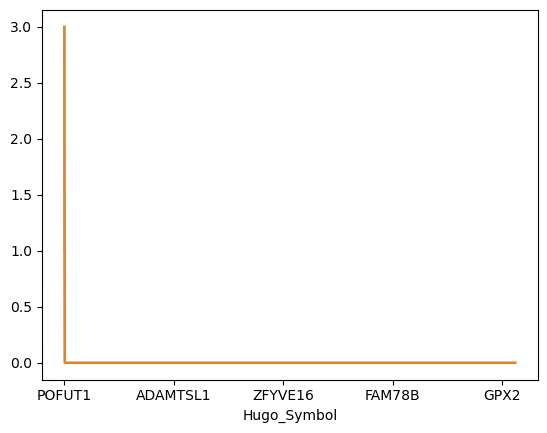

In [71]:
# 臨床データ
generate_target()
generate_features()
# 遺伝子データ
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_gene_expressions = rename_duplicatged_columns(df_gene_expressions)
df_gene_expressions = drop_null4cols(df_gene_expressions)
df_gene_expressions = drop_null4raws(df_gene_expressions)
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_gene_expressions.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_gene_expressions.pkl"
)

# 臨床データと遺伝子データの結合

患者の必要な特徴を含む臨床データと遺伝子データを結合する。

## 臨床データ

**必要な特徴**

目的変数
- RFS_OVER_nMONTHS  

層別化対象候補
- CLAUDIN_SUBTYPE
- NPI_CAT
- TUMOR_CAT
- LYMPH_CAT

## 遺伝子データ
遺伝子データは全ての特徴量を結合する。

In [72]:
left_features = [
    "RFS_MONTHS",
    "RFS_STATUS",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]

df_merged = pd.merge(
    df_MB[left_features],
    df_gene_expressions,
    left_index=True,
    right_index=True,
)
# 半角スペースやバックスラッシュはpklファイル保存時に邪魔になるので置き換え
df_merged["THREEGENE"] = df_merged.THREEGENE.str.replace("/", "_")
df_merged["THREEGENE"] = df_merged.THREEGENE.str.replace(" ", "_")

# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_merged.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_merged4numeric.pkl"
)
df_recurrenced = df_merged.copy()
# save
functions.make_dir(config.INTERIM_PREPROCESSED_RECURRENCE_DIR)
df_merged.to_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

In [10]:
df_recurrenced

,RFS_MONTHS,RFS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,RERE,RNF165,PHF7,CIDEA,TENT2,SLC17A3,...,LOC283104,VN1R4,TRPV5,UGGT1,CR590356,VPS72,CSMD3,CC2D1A,IGSF9,FAM71A
MB-0000,138.65,False,claudin-low,ER-_HER2-,9.738092,6.469688,5.652674,11.558869,8.340484,5.648494,...,5.295203,5.474224,5.415184,7.021679,5.947334,8.010657,5.299815,6.235804,5.947404,5.133576
MB-0002,83.52,False,LumA,ER+_HER2-_High_Prolif,9.013876,5.748717,5.611212,6.199492,8.341091,5.789506,...,5.442257,5.303871,5.507905,7.612797,5.519225,7.988643,5.194247,6.328059,6.938685,5.604560
MB-0005,151.28,True,LumB,NaN,7.963493,5.553056,5.793398,6.489781,8.862815,5.566713,...,5.368716,5.370394,5.314009,6.619220,5.496590,8.044471,5.306294,6.306927,7.397672,5.645597
MB-0006,162.76,False,LumB,NaN,8.177157,5.391160,5.807604,5.319779,8.693784,5.539252,...,5.295628,5.694697,5.410028,6.966482,5.600679,7.527300,5.197607,6.515638,6.175716,5.354582
MB-0008,18.55,True,LumB,ER+_HER2-_High_Prolif,8.050127,5.530582,5.934570,8.787583,8.055626,5.646685,...,5.192858,5.474929,5.389733,6.942461,6.707482,8.115359,5.254136,6.323751,6.272568,5.030636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-7295,194.28,False,LumA,ER+_HER2-_Low_Prolif,8.589374,6.002483,5.802742,5.474550,8.251690,5.546402,...,5.240904,5.521765,5.646490,7.536208,5.824289,8.314500,5.337300,6.278034,6.923887,5.168953
MB-7296,16.09,True,LumB,NaN,8.402660,6.104059,5.256086,6.659117,8.641838,5.522964,...,5.171671,5.441341,5.612519,7.709596,5.899345,8.105717,5.397931,6.325456,6.524268,5.252479
MB-7297,121.18,True,LumB,NaN,8.236918,5.402870,5.571897,5.439574,8.979375,5.804127,...,5.182920,5.339665,5.573512,7.729912,5.588047,7.944622,5.412713,6.254337,6.121864,5.357823
MB-7298,85.10,False,LumB,ER+_HER2-_High_Prolif,8.376571,5.617954,5.631592,5.734358,8.628511,5.472525,...,5.351516,5.361063,5.436273,7.329023,5.713436,8.348807,5.474224,6.415853,7.029076,5.512290


## データ分割

訓練データ、検証データ、テストデータに層化分割する   
比率は(train, val, test)=(0.81, 0.09, 0.1)  
CVは行わずに通常のholdoutで検証は行う（特徴選択を毎度実施するのが厄介なため）


In [73]:
# データ分割のためのクラス
# pythonのミュータブルオブジェクトの外部操作を防ぐためにcopy()の使用&private化
class SplitDataFrame:
    def __init__(self, df, train_size: float = 0.9):
        self.__df = df.copy()
        self.__train_size = train_size

        self.__df_train = None
        self.__df_val = None
        self.__df_train_val = None
        self.__df_test = None

        self.__X_train = None
        self.__y_train = None
        self.__X_val = None
        self.__y_val = None
        self.__X_train_val = None
        self.__y_train_val = None
        self.__X_test = None
        self.__y_test = None

    def split_train_val_test(self):
        # train & test
        self.__df_train_val, self.__df_test = train_test_split(
            self.__df,
            train_size=self.__train_size,
            stratify=self.__df[STRATIFY_NAME],
            random_state=SEED,
        )
        # train & val
        self.__df_train, self.__df_val = train_test_split(
            self.__df_train_val,
            train_size=self.__train_size,
            stratify=self.__df_train_val[STRATIFY_NAME],
            random_state=SEED,
        )

    def split_X_y(self):
        self.__X_train, self.__y_train = (
            self.__df_train.drop(TARGET_NAME, axis=1),
            self.__df_train[TARGET_NAME],
        )
        self.__X_val, self.__y_val = (
            self.__df_val.drop(TARGET_NAME, axis=1),
            self.__df_val[TARGET_NAME],
        )
        self.__X_train_val, self.__y_train_val = (
            self.__df_train_val.drop(TARGET_NAME, axis=1),
            self.__df_train_val[TARGET_NAME],
        )
        self.__X_test, self.__y_test = (
            self.__df_test.drop(TARGET_NAME, axis=1),
            self.__df_test[TARGET_NAME],
        )

    def get_train_val(self):
        return self.__train_val.copy()

    def get_train(self):
        return self.__train.copy()

    def get_val(self):
        return self.__val.copy()

    def get_test(self):
        return self.__test.copy()

    def get_train_val_Xy(self):
        return self.__X_train_val.copy(), self.__y_train_val.copy()

    def get_train_Xy(self):
        return self.__X_train.copy(), self.__y_train.copy()

    def get_val_Xy(self):
        return self.__X_val.copy(), self.__y_val.copy()

    def get_test_Xy(self):
        return self.__X_test.copy(), self.__y_test.copy()

# 前処理パイプライン

In [74]:
def save_preprocessed_df(
    list_train: list(),
    list_test: list(),
    val_step: str,
    save_file_path: str = ".",
):
    """
    params
    list_train: [X_train, y_train]
    list_test: [X_test, y_test]
    """
    # 検証用データセットの保存
    train_path = "{0}/{1}/train".format(save_file_path, val_step)
    test_path = "{0}/{1}/test".format(save_file_path, val_step)

    functions.make_dir(train_path)
    functions.pickle_dump(list_train[0], "{0}/X.pkl".format(train_path))
    functions.pickle_dump(list_train[1], "{0}/y.pkl".format(train_path))
    functions.make_dir(test_path)
    functions.pickle_dump(list_test[0], "{0}/X.pkl".format(test_path))
    functions.pickle_dump(list_test[1], "{0}/y.pkl".format(test_path))


def save_preprocess_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # 検証用データセットの保存
    train_path = "{0}/{1}/train".format(save_file_path, val_step)
    test_path = "{0}/{1}/test".format(save_file_path, val_step)

    functions.make_dir(train_path)
    functions.pickle_dump(pipeline, "{0}/preprocess_pipeline.pkl".format(train_path))
    functions.make_dir(test_path)
    functions.pickle_dump(pipeline, "{0}/preprocess_pipeline.pkl".format(test_path))

In [75]:
def skip_preprocess(df: pd.DataFrame()) -> bool:
    """
    入力データフレームを前処理するか判断

    True: 前処理をする
    False: 前処理をしない
    """
    return True if df.shape[0] > 100  else False


def apply_preprocess(
    df: pd.DataFrame(),
    preprocess_order: dict = {"original_data": []},
    save_file_path: str = None,
):
    _df = df.copy()

    # データが少なすぎる場合は特徴選択しない
    if not skip_preprocess(_df):
        return

    # データ分割
    _sp = SplitDataFrame(_df)
    _sp.split_train_val_test()
    _sp.split_X_y()

    _X_train, _y_train = _sp.get_train_Xy()
    _X_val, _y_val = _sp.get_val_Xy()
    _X_train_val, _y_train_val = _sp.get_train_val_Xy()
    _X_test, _y_test = _sp.get_test_Xy()

    # train&val と train_val&test のそれぞれのセットに適用
    dict_datasets = {
        "val_set": [[_X_train, _y_train], [_X_val, _y_val]],
        "test_set": [[_X_train_val, _y_train_val], [_X_test, _y_test]],
    }
    # 検証用、テスト用それぞれのセットへのパイプラインの適用
    for key, values in dict_datasets.items():
        # set_config(display="diagram")
        _preprocess_pipeline = Pipeline(steps=preprocess_order)
        _preprocess_pipeline.fit(values[0][0], values[0][1])
        values[0][0] = _preprocess_pipeline.transform(values[0][0])
        values[1][0] = _preprocess_pipeline.transform(values[1][0])

        print(
            "X_train: ",
            values[0][0].shape,
            " X_test: ",
            values[1][0].shape,
        )

        # 保存
        if save_file_path:
            save_preprocessed_df(
                list_train=[values[0][0], values[0][1]],
                list_test=[values[1][0], values[1][1]],
                val_step=key,
                save_file_path=save_file_path,
            )
            save_preprocess_pipeline(
                _preprocess_pipeline,
                val_step=key,
                save_file_path=save_file_path,
            )

In [76]:
def loop_preprocess():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    # 実施したい前処理パイプラインの定義
    preprocess_order_dicts = [
        {
            "preprocess_name": "NEWpreprocess4numeric_Sparsepca{0}".format(PCA_PERCENTILE),
            "preprocess_order": [
                (
                    StandardScalerAsDataFrame().__class__.__name__,
                    StandardScalerAsDataFrame(),
                ),
                (
                    #PCAAsDataFrame().__class__.__name__,
                    SparsePCAAsDataFrame().__class__.__name__,
                    #IncrementalPCA(n_components=PCA_PERCENTILE),
                    SparsePCA(n_components=PCA_PERCENTILE, random_state=config.SEED),
                    #PCA(n_components=PCA_PERCENTILE, random_state=config.SEED),
                    #PCA(n_components=PCA_PERCENTILE / 100, random_state=config.SEED),
                ),
            ],
        },
    ]

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        #for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            subgroup = "Normal"
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                drop_columns, axis=1
            )
            print(subgroup, ": ", df.shape)
            for preprocess_order_dict in preprocess_order_dicts:
                output_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    preprocess_order_dict["preprocess_name"],
                )
                apply_preprocess(
                    df,
                    preprocess_order=preprocess_order_dict["preprocess_order"],
                    save_file_path=output_data_path,
                )

In [77]:
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "THREEGENE",
]
# 遺伝子発現量以外の特徴量を削除
drop_columns = [
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]

for subgroup_column in subgroup_columns:  # 各サブグループへの適用
    for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
        #subgroup = "Normal"
        df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
            drop_columns, axis=1
        )
        print(subgroup, ": ", df.shape)

claudin-low :  (214, 20605)
LumA :  (690, 20605)
LumB :  (474, 20605)
Normal :  (147, 20605)
Her2 :  (223, 20605)
Basal :  (209, 20605)
NC :  (6, 20605)


In [31]:

pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_Incpca51/test_set/train/preprocess_pipeline.pkl")
pipe

Pipeline(steps=[('StandardScalerAsDataFrame', StandardScalerAsDataFrame()),
                ('IncrementalPCAAsDataFrame', IncrementalPCA(n_components=51))])

In [35]:
pca = pipe[-1]
loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
         #columns=iris.feature_names,
    )
l = loadings.T

l_1 = l["incrementalpca1"].apply(lambda x: abs(x)).sort_values(ascending=False)
l_1 = pd.DataFrame(l_1)
l_1

,incrementalpca1
WAS,0.855202
PPP1R18,0.847451
FERMT3,0.841887
NCF4,0.840111
ARHGAP9,0.838974
...,...
CHIAP2,0.000072
RAB7A,0.000061
CNTN5,0.000044
SETD1A,0.000013


In [63]:
pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_pca22/test_set/test/X.pkl")
df = pd.DataFrame(pipe)
df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-37.292906,11.787177,37.650660,-5.410705,-2.135610,9.051091,-20.675475,4.847501,-7.586254,-6.656256,...,4.479952,6.752661,10.504359,0.558606,4.903700,3.284424,-5.254897,4.582987,4.703539,0.361979
1,14.124358,-27.133853,-39.003888,7.853505,-3.999148,12.453286,22.943206,-5.758464,7.152888,-2.610991,...,-6.430132,7.033085,-30.262748,5.962721,0.926331,-6.966076,-8.580570,8.527866,-5.247024,-0.518892
2,38.630247,0.856531,24.351695,-12.542405,1.928130,22.086239,12.440438,41.778797,-10.399908,-13.315839,...,2.275719,-5.642012,-3.723662,0.296604,-2.899663,-6.309101,3.626575,0.306889,-1.464490,0.947066
3,-19.256171,-31.384222,-23.851861,24.798481,42.717223,-23.765341,11.164483,-17.399890,5.352225,7.431843,...,-0.809490,0.698199,-15.884444,-18.497667,-8.036476,-3.997399,8.772887,-6.559066,-15.736119,0.558233
4,-16.718245,13.835531,9.828602,-26.304428,-43.337108,11.002689,4.925943,-12.280808,11.064578,18.611854,...,3.057939,1.630502,-8.906511,-1.512533,10.617282,-0.406353,13.078334,6.363332,0.110180,2.159059
5,-48.618336,-8.950812,-5.285529,-6.620157,11.197359,-16.786012,2.738854,-16.532826,14.860286,3.192048,...,-17.803536,-0.982096,-17.126021,-7.582669,-0.836616,-4.331244,-10.803394,15.101957,-2.562504,6.044225
6,115.779919,45.452914,52.242500,-10.284975,22.537746,-22.185994,-10.716870,-8.922673,0.773949,5.031795,...,-3.275951,-6.499813,-10.196879,-11.695083,4.500411,11.946903,-12.152205,5.831329,-2.128071,-0.577548
7,-20.386701,-1.915418,17.456507,3.898265,7.187692,8.442834,-26.751216,-8.438848,12.717475,4.379782,...,29.538561,7.299685,3.224907,10.329965,0.000139,-2.598047,-2.536932,0.855163,4.242517,-2.585902
8,61.855788,33.636893,16.140705,-6.348190,23.640439,-23.830106,-25.004079,5.452108,-8.792505,3.577329,...,13.742131,11.015862,0.018573,9.160326,5.582204,-6.034309,4.032996,8.105147,-4.405137,6.998723
9,75.537337,4.693030,3.132528,-1.634549,5.506862,-27.422263,-10.409870,-31.214023,2.936245,2.771442,...,6.020740,1.987869,3.038879,8.219053,-0.361482,1.756720,-8.061609,0.282994,4.275543,4.789769


In [60]:
pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_pca44/test_set/test/y.pkl")
pipe

,RFS_STATUS,RFS_MONTHS
MB-3355,False,107.57
MB-0418,False,100.72
MB-5441,False,9.57
MB-0346,True,20.16
MB-2792,True,86.25
MB-0361,False,14.87
MB-4360,True,11.12
MB-2922,True,14.01
MB-4935,False,191.64
MB-4003,True,26.45


In [21]:
pca = pipe[-1]
loadings = pd.DataFrame(
        pca.components_,
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
         #columns=iris.feature_names,
    )
l = loadings.T

l_1 = l["pca1"].apply(lambda x: abs(x)).sort_values(ascending=False)
l_1 = pd.DataFrame(l_1)
l_1

,pca1
IFI30,2.414642e-02
FAM13B,2.382825e-02
ZBTB4,2.337284e-02
SMARCA2,2.336741e-02
CACHD1,2.325252e-02
...,...
PTCH2,1.160973e-06
WNT7A,6.993185e-07
ZNF609,6.589182e-07
CDC40,4.094891e-07


In [21]:
pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_Sparsepca2/test_set/train/preprocess_pipeline.pkl")
pipe

Pipeline(steps=[('StandardScalerAsDataFrame', StandardScalerAsDataFrame()),
                ('SparsePCAAsDataFrame',
                 SparsePCA(n_components=2, random_state=100))])

In [23]:
sparsepca = pipe[-1]
loadings = pd.DataFrame(
        sparsepca.components_,
        index=sparsepca.get_feature_names_out(),
        columns=sparsepca.feature_names_in_,
         #columns=iris.feature_names,
    )
l = loadings.T

l_1 = l["sparsepca1"].apply(lambda x: abs(x)).sort_values(ascending=False)
l_1 = pd.DataFrame(l_1)
l_1

,sparsepca1
TGFB3,0.031195
SVEP1,0.029710
CDCA3,0.029238
JAM3,0.029207
ZCCHC24,0.028752
...,...
COL18A1-AS1,0.000000
MED12L,0.000000
AB231761,0.000000
DEDD2,0.000000


In [22]:
pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_Sparsepca2/test_set/train/preprocess_pipeline.pkl")
pipe
pca = pipe[-1]
contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
contribution_ratios

AttributeError: 'SparsePCA' object has no attribute 'explained_variance_ratio_'

In [22]:
pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_Incpca5/test_set/train/preprocess_pipeline.pkl")
pca = pipe[-1]
contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
contribution_ratios

,0
0,0.102370
1,0.049422
2,0.037488
3,0.031606
4,0.028610


In [23]:
cum = cumulative_contribution_ratios = contribution_ratios.cumsum()
cum

,0
0,0.102370
1,0.151792
2,0.189280
3,0.220886
4,0.249496


In [24]:
c = cum.iloc[-1][0]
c

0.24949605860814725

In [26]:
"""
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Normal",
    "Her2",
    "Basal",
]

p = 2
c = 0
c_min = 0

while c_min < 1:
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_preprocess()
    list_c = []
    subtype = "LumA"
    #for subtype in subtypes:
    pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/{0}/NEWpreprocess4numeric_Incpca{1}/test_set/train/preprocess_pipeline.pkl".format(subtype, p))
    pca = pipe[-1]
    contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
    cum = cumulative_contribution_ratios = contribution_ratios.cumsum()
    c = cum.iloc[-1][0]
    if c >= 0.95:
        print("次元数:{0},サブタイプ:{1},累積寄与率:{2}".format(p, subtype, c))
    #list_c.append(c)
    #c_min = min(list_c)
    c_min = 1
    print(c_min)
    p += 1
"""

'\nsubtypes = [\n    "claudin-low",\n    "LumA",\n    "LumB",\n    "Normal",\n    "Her2",\n    "Basal",\n]\n\np = 2\nc = 0\nc_min = 0\n\nwhile c_min < 1:\n    print("++++++++++" * 10)\n    print(p)\n    PCA_PERCENTILE = p\n    loop_preprocess()\n    list_c = []\n    subtype = "LumA"\n    #for subtype in subtypes:\n    pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/{0}/NEWpreprocess4numeric_Incpca{1}/test_set/train/preprocess_pipeline.pkl".format(subtype, p))\n    pca = pipe[-1]\n    contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)\n    cum = cumulative_contribution_ratios = contribution_ratios.cumsum()\n    c = cum.iloc[-1][0]\n    if c >= 0.95:\n        print("次元数:{0},サブタイプ:{1},累積寄与率:{2}".format(p, subtype, c))\n    #list_c.append(c)\n    #c_min = min(list_c)\n    c_min = 1\n    print(c_min)\n    p += 1\n'

In [20]:

subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Normal",
    "Her2",
    "Basal",
]

p = 2
c = 0
c_min = 0

while c_min < 0.95:
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_preprocess()
    list_c = []
    subtype = "Basal"
    #for subtype in subtypes:
    pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/{0}/NEWpreprocess4numeric_pca{1}/test_set/train/preprocess_pipeline.pkl".format(subtype, p))
    pca = pipe[-1]
    contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
    cum = cumulative_contribution_ratios = contribution_ratios.cumsum()
    c = cum.iloc[-1][0]
    if c >= 0.95:
        print("次元数:{0},サブタイプ:{1},累積寄与率:{2}".format(p, subtype, c))
    #list_c.append(c)
    #c_min = min(list_c)
    c_min = c
    print(c_min)
    p += 1

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2
Basal :  (209, 20605)
X_train:  (169, 2)  X_test:  (19, 2)
X_train:  (188, 2)  X_test:  (21, 2)


AttributeError: 'SparsePCA' object has no attribute 'explained_variance_ratio_'

In [ ]:
#SparsePCA用
subtypes = [
    "claudin-low",
    "LumA",
    "LumB",
    "Normal",
    "Her2",
    "Basal",
]
p = 16
for i in range(16,115,1):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_preprocess()
    list_c = []
    subtype = "Normal"
    #for subtype in subtypes:
    pipe =pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/{0}/NEWpreprocess4numeric_Sparsepca{1}/test_set/train/preprocess_pipeline.pkl".format(subtype, p))
    sparse_pca = pipe[-1]
    p += 1

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
16
Normal :  (147, 20605)
X_train:  (118, 16)  X_test:  (14, 16)
X_train:  (132, 16)  X_test:  (15, 16)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
17
Normal :  (147, 20605)
X_train:  (118, 17)  X_test:  (14, 17)
X_train:  (132, 17)  X_test:  (15, 17)
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
18
Normal :  (147, 20605)


In [33]:
list_c

[0.8419661488259813,
 0.5986144423303619,
 0.6351598430701935,
 0.9633091635971155,
 0.8086282582585733,
 0.8254370555070722]

In [88]:
"""
for p in tqdm(range(25, 26)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_preprocess()
"""

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
claudin-low :  (214, 20605)
X_train:  (172, 25)  X_test:  (20, 25)
X_train:  (192, 25)  X_test:  (22, 25)
LumA :  (690, 20605)
X_train:  (558, 25)  X_test:  (63, 25)
X_train:  (621, 25)  X_test:  (69, 25)
LumB :  (474, 20605)
X_train:  (383, 25)  X_test:  (43, 25)
X_train:  (426, 25)  X_test:  (48, 25)
Normal :  (147, 20605)
X_train:  (118, 25)  X_test:  (14, 25)
X_train:  (132, 25)  X_test:  (15, 25)
Her2 :  (223, 20605)
X_train:  (180, 25)  X_test:  (20, 25)
X_train:  (200, 25)  X_test:  (23, 25)
Basal :  (209, 20605)
X_train:  (169, 25)  X_test:  (19, 25)


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.40s/it]

X_train:  (188, 25)  X_test:  (21, 25)
NC :  (6, 20605)


In [33]:
def apply_preprocess2late_recurrences(
    df: pd.DataFrame(),
    preprocess_pipeline_path: str,
    save_file_path: str = None,
):

    _df = df.copy()
    _X = _df.drop(TARGET_NAME, axis=1)
    _y = _df[TARGET_NAME]
    try:  
        # 検証用、テスト用それぞれのセットへのパイプラインの適用
        _preprocess_pipeline = functions.pickle_load(
            preprocess_pipeline_path + "/preprocess_pipeline.pkl"
        )    
        display(_X.shape)
        _X = _preprocess_pipeline.transform(_X)
        display(_X.shape)

        # 保存
        if save_file_path:
            functions.make_dir(save_file_path)
            functions.pickle_dump(_X, save_file_path + "/X.pkl")
            functions.pickle_dump(_y, save_file_path + "/y.pkl")
    except FileNotFoundError as e:
        print("{} not found.".format(preprocess_pipeline_path))

In [36]:
def loop_late_recurrences_data():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    preprocess_order_dicts = [
        {
            "preprocess_name": "NEWpreprocess4numeric_pca{0}".format(PCA_PERCENTILE),
        }
    ]
    val_step = "test_set"

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            df = df_recurrenced[df_recurrenced[subgroup_column] == subgroup].drop(
                drop_columns, axis=1
            )
            df = df[(df.RFS_STATUS == True) & (df.RFS_MONTHS > 60)]
            if df.shape[0] < 5:
                continue

            print(subgroup, ": ", df.shape)
            for preprocess_order_dict in preprocess_order_dicts:
                subgroup_path = "./{0}/{1}/{2}/{3}".format(
                    subgroup_column,
                    subgroup,
                    preprocess_order_dict["preprocess_name"],
                    val_step,
                )
                input_pipe_path = "./{0}/{1}/{2}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR, subgroup_path, "train"
                )
                output_data_path = "./{0}/{1}/{2}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_path,
                    "late_recurrences",
                )
                apply_preprocess2late_recurrences(df, input_pipe_path, output_data_path)

In [37]:
# 実施したい前処理パイプラインの定義
for p in tqdm(range(2, 523)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p
    loop_late_recurrences_data()

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
520
claudin-low :  (23, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/NEWpreprocess4numeric_pca520/test_set/train not found.
LumA :  (122, 20605)


(122, 20603)

(122, 520)

 20%|█████████████████                                                                    | 1/5 [00:00<00:03,  1.28it/s]

LumB :  (89, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_pca520/test_set/train not found.
Normal :  (28, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_pca520/test_set/train not found.
Her2 :  (31, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_pca520/test_set/train not found.
Basal :  (9, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_pca520/test_set/train not found.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
521
claudin-low :  (23, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/NEWpreprocess4numeric_pca521/test_set/train not found.
LumA :  (122, 20605)


(122, 20603)

(122, 521)

 40%|██████████████████████████████████                                                   | 2/5 [00:01<00:02,  1.36it/s]

LumB :  (89, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_pca521/test_set/train not found.
Normal :  (28, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_pca521/test_set/train not found.
Her2 :  (31, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_pca521/test_set/train not found.
Basal :  (9, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_pca521/test_set/train not found.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
522
claudin-low :  (23, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/NEWpreprocess4numeric_pca522/test_set/train not found.
LumA :  (122, 20605)


(122, 20603)

(122, 522)

 60%|███████████████████████████████████████████████████                                  | 3/5 [00:02<00:01,  1.37it/s]

LumB :  (89, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_pca522/test_set/train not found.
Normal :  (28, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_pca522/test_set/train not found.
Her2 :  (31, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_pca522/test_set/train not found.
Basal :  (9, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_pca522/test_set/train not found.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
523
claudin-low :  (23, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/NEWpreprocess4numeric_pca523/test_set/train not found.


 80%|████████████████████████████████████████████████████████████████████                 | 4/5 [00:02<00:00,  1.74it/s]

LumA :  (122, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/LumA/NEWpreprocess4numeric_pca523/test_set/train not found.
LumB :  (89, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_pca523/test_set/train not found.
Normal :  (28, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Normal/NEWpreprocess4numeric_pca523/test_set/train not found.
Her2 :  (31, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_pca523/test_set/train not found.
Basal :  (9, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_pca523/test_set/train not found.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
524
claudin-low :  (23, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/NEWpreprocess4numeric_pca524/test_set/train not found.
LumA :  (122, 20605)
./../data/inte

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]

./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_pca524/test_set/train not found.
Basal :  (9, 20605)
./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/Basal/NEWpreprocess4numeric_pca524/test_set/train not found.


In [20]:
preprocess_pipeline_path

NameError: name 'preprocess_pipeline_path' is not defined

In [ ]:
df_recurrenced

# recheck data shape

In [ ]:
df_recurrenced.shape

In [ ]:
df_recurrenced.RFS_STATUS.value_counts()

In [ ]:
df_recurrenced.groupby("CLAUDIN_SUBTYPE").RFS_STATUS.value_counts()

In [ ]:
df_recurrenced[
    (df_recurrenced.RFS_MONTHS > 60) & (df_recurrenced.RFS_STATUS == True)
].groupby("CLAUDIN_SUBTYPE").RFS_STATUS.value_counts()

In [ ]:
df_recurrenced[(df_recurrenced.RFS_STATUS == True)].groupby(
    "CLAUDIN_SUBTYPE"
).RFS_STATUS.value_counts()